# Region of Interest (ROI) Extraction from ORIGA dataset images

## Findings so far:
- brightest spot & template matching works pretty well
- intensity weighted centroid is not very good
- thresholding a channel gives too big ROI areas
- TM can be improved by using more templates and averaging the results
- TM takes too long (use rescaled smaller image and template)
- BS often cuts through the OD (try to find other method for cropping the square around the brightest point)
- combination of TM followed by TC gives slight improvement (could be further improved by using dist. transform)


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
base_dir = '../data/ORIGA/Images'
base_mask_dir = '../data/ORIGA/Masks'

idx = 143
files = os.listdir(base_dir)
file = os.path.join(base_dir, files[idx])

bgr_img = cv.imread(file)
rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
grey_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)

mask = cv.imread(os.path.join(base_mask_dir, files[idx].replace('jpg', 'png')), cv.IMREAD_GRAYSCALE)

## Method 1: Intensity weighted centroid

In [ ]:
from utils import circular_kernel, gaussian_kernel, parabolic_kernel


def intensity_weighted_centroid(image, width: int = 512, height: int = 512, channel: int = -1,
                                equalize: bool = True, clahe: bool = True, square: bool = True,
                                dampening: str = 'circular', k_size: int = None, quantile: float = None):
    # Select the channel that is going to be used for centroid calculation
    weights = image[..., channel] if channel != -1 else cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Equalize histogram to increase contrast
    if equalize:
        weights = cv.equalizeHist(weights)

    # Contrast Limited Adaptive Histogram Equalization
    if clahe:
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
        weights = clahe.apply(weights)

    # Convert to 32-bit float and normalize
    weights = weights.astype(np.float32)
    weights -= weights.min()
    weights = weights / weights.max()

    # Apply Gaussian blur to smooth out the image
    if k_size is not None:
        weights = cv.GaussianBlur(weights, (k_size, k_size), 0)

    # Square the weights to increase the contrast
    if square:
        weights = weights ** 2
        weights = weights / weights.sum()

    # Dampen the weights close to the corners
    dampening = dampening.lower()
    if dampening == 'circular':
        damping_map = circular_kernel(weights.shape[1], weights.shape[0])
    elif dampening == 'gaussian':
        damping_map = gaussian_kernel(weights.shape[1], weights.shape[0])
    elif dampening == 'parabolic':
        damping_map = parabolic_kernel(image.shape[1], image.shape[0])
    else:
        damping_map = np.ones_like(weights)
    weights = weights * damping_map

    # Cut off the bottom % of the weights
    if quantile is not None:
        weights[weights < np.quantile(weights, quantile)] = 0

    # Find the centroid
    x = np.arange(weights.shape[1])
    y = np.arange(weights.shape[0])
    x, y = np.meshgrid(x, y)

    x_weighted = x * weights
    y_weighted = y * weights
    total_intensity = np.sum(weights)

    x_mean = np.sum(x_weighted) / total_intensity
    y_mean = np.sum(y_weighted) / total_intensity

    # _, ax = plt.subplots(2, 3, figsize=(15, 8))
    # ax = ax.ravel()
    # ax[0].imshow(x)
    # ax[1].imshow(y)
    # ax[2].imshow(weights)
    # ax[3].imshow(x_weighted)
    # ax[4].imshow(y_weighted)
    # ax[5].imshow(image)
    # plt.show()

    return int(x_mean - width / 2), int(y_mean - height / 2), width, height


img = rgb_img.copy()
x, y, w, h = intensity_weighted_centroid(
    img, 512, 512, channel=-1, equalize=True, clahe=True, square=True,
    dampening='circular', k_size=65, quantile=0.9,
)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()

## Method 2: Brightest spot algorithm

In [ ]:
def brightest_spot(image, width: int = 512, height: int = 512, channel: int = -1,
                   dampening: str = 'circular', k_size: int = 65):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if channel == -1 else image[..., channel]
    image = image.astype(np.float32) / 255.0

    # Dampen the weights close to the corners
    dampening = dampening.lower()
    if dampening == 'circular':
        damping_map = circular_kernel(image.shape[1], image.shape[0])
    elif dampening == 'gaussian':
        damping_map = gaussian_kernel(image.shape[1], image.shape[0])
    elif dampening == 'parabolic':
        damping_map = parabolic_kernel(image.shape[1], image.shape[0])
    else:
        damping_map = np.ones_like(image)
    image = image * damping_map

    # Apply Gaussian blur to smooth out the image
    blurred_img = cv.GaussianBlur(image, (k_size, k_size), cv.BORDER_DEFAULT)

    # Find the brightest spot
    max_val = np.max(blurred_img)
    max_idx = np.where(blurred_img == max_val)

    # Average the brightest spots in case there are multiple
    max_idx = np.mean(max_idx, axis=1)

    # Find the centroid of the brightest spot
    center_x = np.mean(max_idx[1])
    center_y = np.mean(max_idx[0])

    return int(center_x - width / 2), int(center_y - height / 2), width, height


img = rgb_img.copy()
x, y, w, h = brightest_spot(img, 512, 512, channel=-1, dampening='circular', k_size=65)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()

## Method 3: Template Matching

In [ ]:
# Load the templates
bounds = {
    0: (800, 1300, 1350, 1750),
    1: (650, 1150, 850, 1250),
    2: (700, 1200, 750, 1250),
    3: (750, 1250, 1400, 1850),
    4: (770, 1220, 750, 1180),
    20: (670, 1180, 650, 1100),
    21: (600, 1100, 1050, 1500),
    22: (720, 1170, 1070, 1500),
    # 24
}
templates = []
for idx, bound in bounds.items():
    file = os.path.join(base_dir, files[idx])
    bgr_img = cv.imread(file)
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
    template = rgb_img.copy()[bound[0]:bound[1], bound[2]:bound[3], :]
    templates.append(template)

In [ ]:
def template_matching(image, templates, margin_x: int = 50, margin_y: int = 50,
                      scale: float = 1.0, min_confidence: float = 0.5, reduce: str = 'max'):
    bboxes = []

    # Resize image to smaller size for faster computation
    if scale < 1.0:
        image = cv.resize(image, (0, 0), fx=scale, fy=scale)

    for template in templates:
        # Resize template to smaller size
        if scale < 1.0:
            template = cv.resize(template, (0, 0), fx=scale, fy=scale)

        # Safety check to make sure the template is smaller than the image
        if image.shape[0] < template.shape[0] or image.shape[1] < template.shape[1]:
            continue

        # Apply template Matching
        matched_image = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(matched_image)

        # Get the bounding box
        top_left_x, top_left_y = max_loc
        height, width = template.shape[:2]

        # Rescale back to original size
        if scale < 1.0:
            top_left_x = int(top_left_x / scale)
            top_left_y = int(top_left_y / scale)
            width = int(width / scale)
            height = int(height / scale)

        # Add margin to the bounding box
        top_left_x -= margin_x
        top_left_y -= margin_y
        width += 2 * margin_x
        height += 2 * margin_y

        bboxes.append((top_left_x, top_left_y, width, height, max_val))

    # Combine the bounding boxes
    bboxes = np.array(bboxes)
    # Sort by confidence
    bboxes = bboxes[np.argsort(bboxes[:, 4])[::-1]]
    # Remove low confidence bounding boxes
    bboxes = bboxes[bboxes[:, 4] > min_confidence]

    reduce = reduce.lower()
    if reduce == 'mean':
        return np.mean(bboxes, axis=0)[:4].astype(int)
    elif reduce == 'median':
        return np.median(bboxes, axis=0)[:4].astype(int)
    elif reduce == 'max':
        return np.max(bboxes, axis=0)[:4].astype(int)
    elif reduce == 'min':
        return np.min(bboxes, axis=0)[:4].astype(int)
    elif reduce == 'join':
        # Join the bounding boxes in extreme points
        x_min = np.min(bboxes[:, 0])
        y_min = np.min(bboxes[:, 1])
        x_max = np.max(bboxes[:, 0] + bboxes[:, 2])
        y_max = np.max(bboxes[:, 1] + bboxes[:, 3])
        return np.array([x_min, y_min, x_max - x_min, y_max - y_min]).astype(int)
    return bboxes[:, :4].astype(int)


img = rgb_img.copy()
x, y, w, h = template_matching(img, templates, margin_x=50, margin_y=50, scale=0.35, reduce='mean')
img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)

# res = template_matching(img, templates, margin_x=50, margin_y=50, scale=0.35, reduce='')
# for x, y, w, h in res:
#     img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)

plt.imshow(img)
plt.show()

## Method 4: Thresholding channel

In [ ]:
from utils import keep_largest_component, get_bounding_box


def threshold_channel(image, margin_x: int = 50, margin_y: int = 50, channel: int = 2,
                      crop_size: int | float = 256, k_size: int = 35):
    # Crop the image to remove the black background
    if isinstance(crop_size, float):
        crop_size = int(crop_size * image.shape[0])
    if crop_size > 0:
        image = image[crop_size: -crop_size, crop_size: -crop_size, :]

    # Get the specified channel (red, green, blue, or grey)
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if channel == -1 else image[..., channel]

    # Otsu thresholding
    _, image = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Dilate the mask
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (k_size, k_size))
    image = cv.dilate(image, kernel)

    # Get bounding box of largest connected component
    image = keep_largest_component(image)
    top_left_x, top_left_y, width, height = get_bounding_box(image)

    top_left_x += crop_size - margin_x
    top_left_y += crop_size - margin_y
    width += 2 * margin_x
    height += 2 * margin_y

    return top_left_x, top_left_y, width, height


img = rgb_img.copy()
x, y, w, h = threshold_channel(img, channel=2, crop_size=200, k_size=35)
cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(img)
plt.show()


# Comparing methods

In [ ]:
def portion_inside_bbox(binary_mask, bounding_box):
    # Extract bounding box coordinates (x, y, w, h)
    x, y, w, h = bounding_box

    # Ensure the bounding box coordinates are within the bounds of the binary mask
    x = max(0, x)
    y = max(0, y)
    w = min(w, binary_mask.shape[1] - x)
    h = min(h, binary_mask.shape[0] - y)

    # Extract the region of interest (ROI) from the binary mask
    roi = binary_mask[y:y + h, x:x + w]

    # Calculate the total number of 1s in the binary mask and the number of 1s in the ROI
    total_ones = binary_mask[binary_mask > 0].sum()
    ones_inside_bbox = roi[roi > 0].sum()

    # Calculate the portion of 1s inside the bounding box
    portion = ones_inside_bbox / total_ones if total_ones > 0 else 0.0

    return portion


1.0
1.0


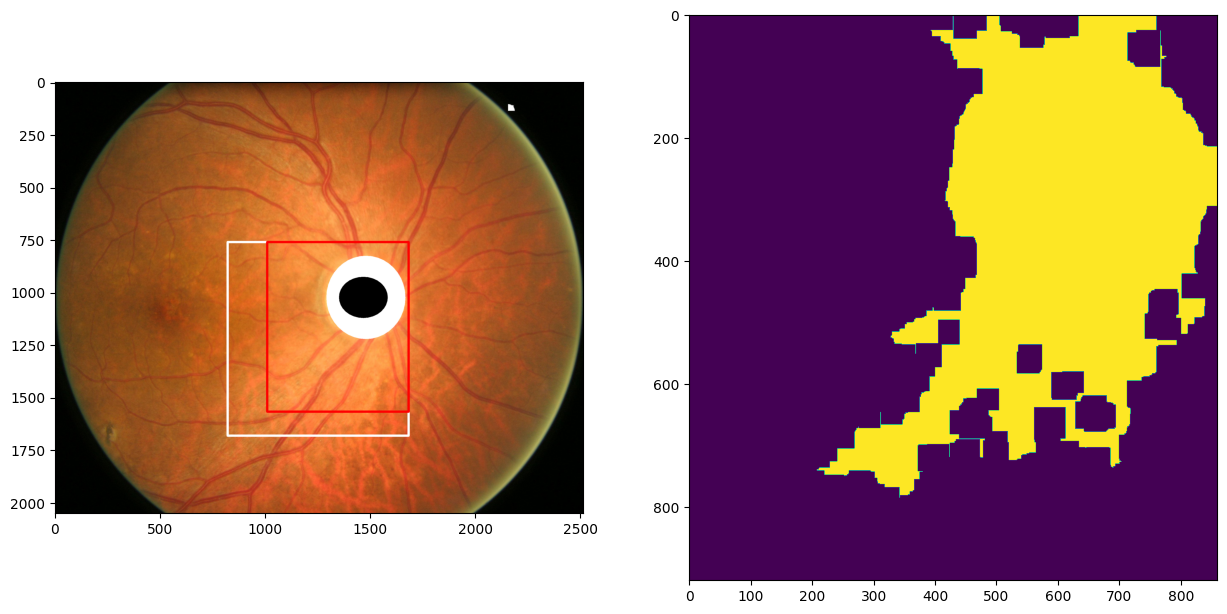

In [18]:
def extra(image, margin: int = 20):
    x, y, w, h = template_matching(image, templates, margin_x=0, margin_y=0, scale=0.1, reduce='join')
    image = image[y:y + h, x:x + w, :]

    r, g, b = cv.split(image)  # Use blue channel for better contrast
    _, b = cv.threshold(b, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Refine the mask with morphological operations
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (35, 35))
    b = cv.morphologyEx(b, cv.MORPH_CLOSE, kernel)

    # Keep the largest connected component
    b = keep_largest_component(b)
    bbox = get_bounding_box(b)

    # Offset the bounding box and add margin
    bbox = (bbox[0] + x, bbox[1] + y, bbox[2], bbox[3])
    bbox = (bbox[0] - margin, bbox[1] - margin, bbox[2] + 2 * margin, bbox[3] + 2 * margin)

    # Clip to cropped template image bounds and image bounds
    bbox = (
        max(0, bbox[0], x),
        max(0, bbox[1], y),
        min(bbox[2] + bbox[0], x + w) - max(0, bbox[0], x),
        min(bbox[3] + bbox[1], y + h) - max(0, bbox[1], y),
    )

    return bbox, b, x, y, w, h


img = rgb_img.copy()
bbox, b, x, y, w, h = extra(img)

img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 10)
img = cv.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255, 0, 0), 10)
img[mask == 1] = (255, 255, 255)
img[mask == 2] = (0, 0, 0)

print(portion_inside_bbox(mask, (x, y, w, h)))
print(portion_inside_bbox(mask, bbox))

_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(img)
ax[1].imshow(b)
plt.show()

In [ ]:
for idx in [155, 255, 313, 541, 482, 478, 435, 412]:
    # idx = np.random.randint(0, len(files))
    file = os.path.join(base_dir, files[idx])

    img = cv.imread(file)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    mask = cv.imread(os.path.join(base_mask_dir, files[idx].replace('jpg', 'png')), cv.IMREAD_GRAYSCALE)
    bbox, b, x, y, w, h = extra(img)

    img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 10)
    img = cv.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (255, 0, 0), 10)
    img[mask == 1] = (255, 255, 255)
    img[mask == 2] = (0, 0, 0)

    print(portion_inside_bbox(mask, (x, y, w, h)))
    print(portion_inside_bbox(mask, bbox))

    _, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(img)
    ax[1].imshow(b)
    plt.title(files[idx])
    plt.show()

In [ ]:
from collections import defaultdict

percentages = defaultdict(list)
areas = defaultdict(list)

for file in files:
    bgr_img = cv.imread(os.path.join(base_dir, file))
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)

    mask = cv.imread(os.path.join(base_mask_dir, file.replace('jpg', 'png')), cv.IMREAD_GRAYSCALE)
    result = rgb_img.copy()
    result[mask == 1] = (255, 255, 255)
    result[mask == 2] = (0, 0, 0)

    # x, y, w, h = brightest_spot(rgb_img, 800, 800, channel=-1, dampening='circular', k_size=65)
    # percentages['brightest_spot'].append(portion_inside_bbox(mask, (x, y, w, h)))
    # cv.rectangle(result, (x, y), (x + w, y + h), (255, 0, 0), 10)
    # cv.putText(result, 'Brightest Spot', (10, 100), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 10)

    # x, y, w, h = threshold_channel(rgb_img, channel=0, margin_x=50, margin_y=50, crop_size=250, k_size=35)
    # percentages['threshold_channel'].append(portion_inside_bbox(mask, (x, y, w, h)))
    # cv.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 10)
    # cv.putText(result, 'Thresholding Channel', (10, 200), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 10)

    x, y, w, h = template_matching(rgb_img, templates, margin_x=0, margin_y=0, scale=0.1, reduce='join')
    percentages['template_matching_join'].append(portion_inside_bbox(mask, (x, y, w, h)))
    cv.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 10)
    cv.putText(result, 'Template Matching (join)', (10, 300), cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 10)
    w1, h1 = w, h

    # x, y, w, h = template_matching(rgb_img, templates, margin_x=50, margin_y=50, scale=0.1, reduce='mean')
    # percentages['template_matching_mean'].append(portion_inside_bbox(mask, (x, y, w, h)))
    # cv.rectangle(result, (x, y), (x + w, y + h), (255, 0, 255), 10)
    # cv.putText(result, 'Template Matching (mean)', (10, 400), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 10)

    (x, y, w, h), *_ = extra(rgb_img, 150)
    percentages['extra'].append(portion_inside_bbox(mask, (x, y, w, h)))
    cv.rectangle(result, (x, y), (x + w, y + h), (255, 255, 0), 10)
    cv.putText(result, 'Extra', (10, 500), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 10)
    w2, h2 = w, h

    result = cv.cvtColor(result, cv.COLOR_RGB2BGR)
    cv.imwrite(f'../logs/{file}', result)
    # print(file)

    if portion_inside_bbox(mask, (x, y, w, h)) < 1.0:
        print('------------', file)
    # plt.figure(figsize=(12, 6))
    # plt.imshow(result)
    # plt.show()
    # break
{key: np.mean(val) for key, val in percentages.items()}

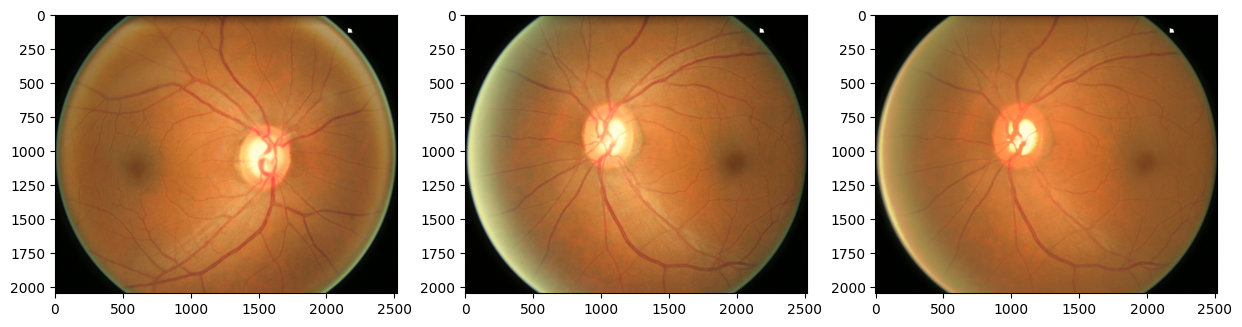

In [21]:
from utils import source_to_target_correction

img1 = cv.imread('../data/ORIGA/Images/001.jpg')
img2 = cv.imread('../data/ORIGA/Images/002.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img2 = cv.resize(img2, (img1.shape[1], img1.shape[0]))

img3 = source_to_target_correction(img2, img1)
_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
plt.show()